In [2]:
from framefinder import framelabels
base_model = "all-mpnet-base-v2"
candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
    "Other: any coherent group of frames not covered by the above categories",
]

framing_labels = framelabels.FramingLabels("facebook/bart-large-mnli", candidate_labels)

In [3]:
import os
import numpy as np
import pandas as pd

def merge_csvs(directory):
    assert(os.path.exists(directory))
    files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    assert(files)

    dfs = []
    for file in files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        dfs.append(pd.read_csv(file_path, header=[0]))
    return pd.concat(dfs, axis=0)


def create_histogram(df, thresholds="auto"):
    histogram_df = pd.DataFrame()

    for col in df.columns:  # for each frame dimension
        hist, bin_edges = np.histogram(df[col], bins=thresholds)
        bin_labels = [
            f"{col}_bin_{round(thresholds[i], 2)}" for i in range(1, len(bin_edges))
        ]

        for label, count in zip(bin_labels, hist):
            histogram_df[label] = [count]

    return histogram_df

In [4]:
all_cop_reports = merge_csvs("COP/dumps/labels/by_year")
MEAN = means = all_cop_reports.mean()
STD = stds = all_cop_reports.std()
maxs = all_cop_reports.max()
mins = all_cop_reports.min()

for col in all_cop_reports.columns:
    print(f"Label: {col}")
    print(f"\tMean {means[col]}")
    print(f"\tStandard Deviation {stds[col]}")
    print(f"\tMax {maxs[col]}")
    print(f"\tMin {mins[col]}")

Label: Economic
	Mean 0.5416103827465613
	Standard Deviation 0.3122295184043343
	Max 0.9987136125564576
	Min 4.924911991111003e-05
Label: Capacity
	Mean 0.464349719865461
	Standard Deviation 0.25655391051946663
	Max 0.9974545240402222
	Min 8.105689630610868e-05
Label: Morality
	Mean 0.13588483155055053
	Standard Deviation 0.19953264049149905
	Max 0.9972098469734192
	Min 1.636975684959907e-05
Label: Fairness
	Mean 0.21694632773082542
	Standard Deviation 0.2336766192628314
	Max 0.9982173442840576
	Min 3.113565981038846e-05
Label: Legality,
	Mean 0.10877176512380221
	Standard Deviation 0.18441943522014026
	Max 0.985959529876709
	Min 2.492948442522902e-05
Label: Policy
	Mean 0.24758641486419108
	Standard Deviation 0.2601466545121543
	Max 0.9956098794937134
	Min 4.478405026020482e-05
Label: Crime
	Mean 0.13832994828964515
	Standard Deviation 0.19784741968892602
	Max 0.9776657819747924
	Min 2.2979846107773483e-05
Label: Security
	Mean 0.28895035533332164
	Standard Deviation 0.258055612576659

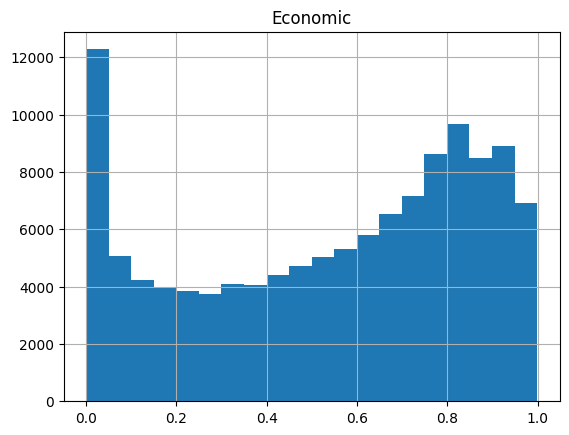

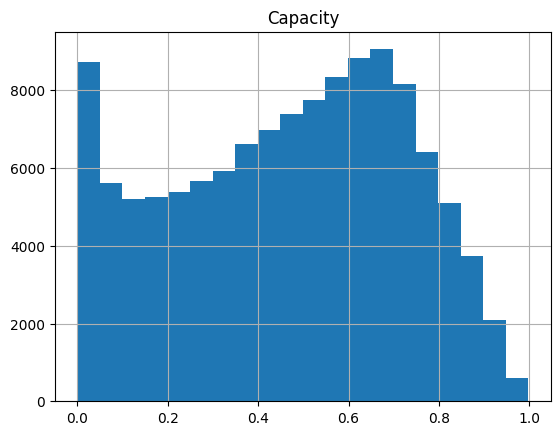

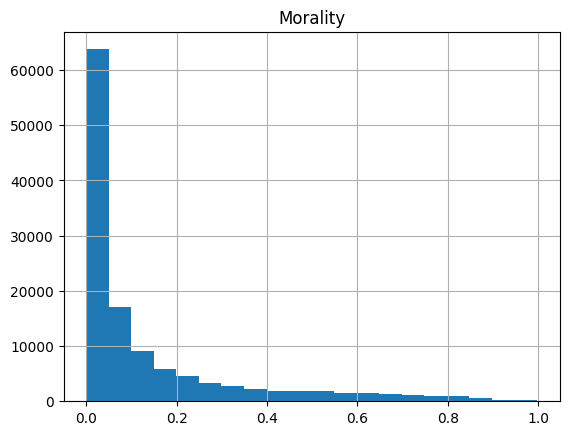

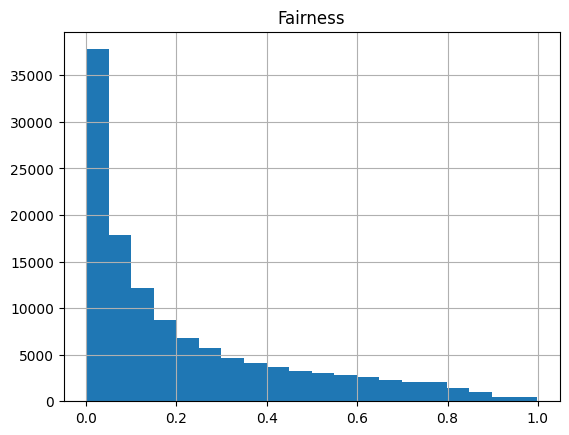

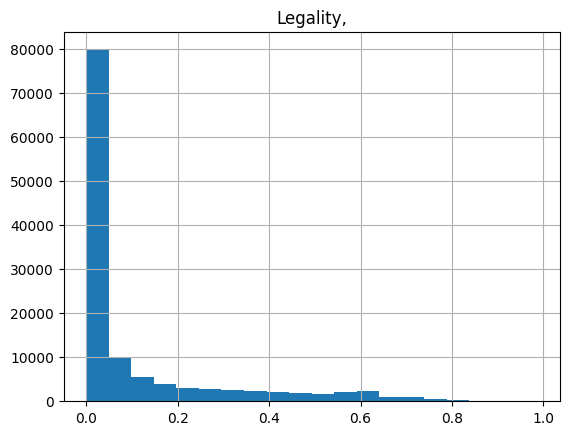

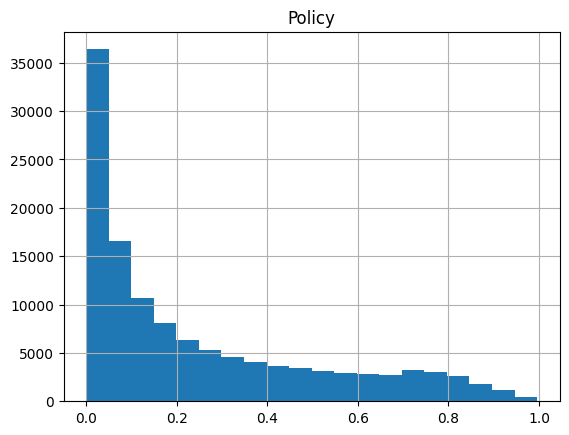

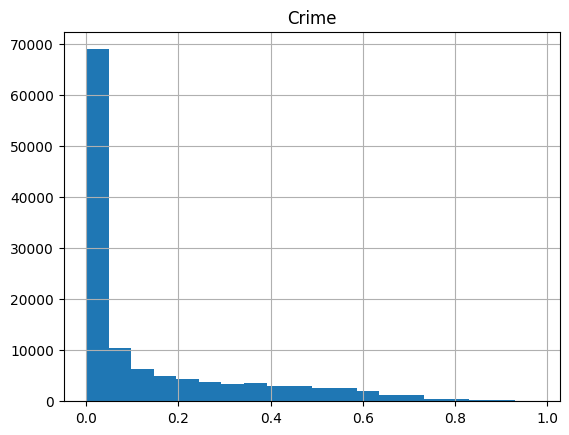

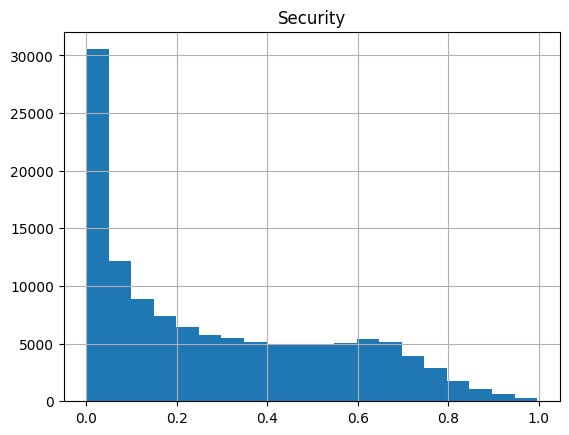

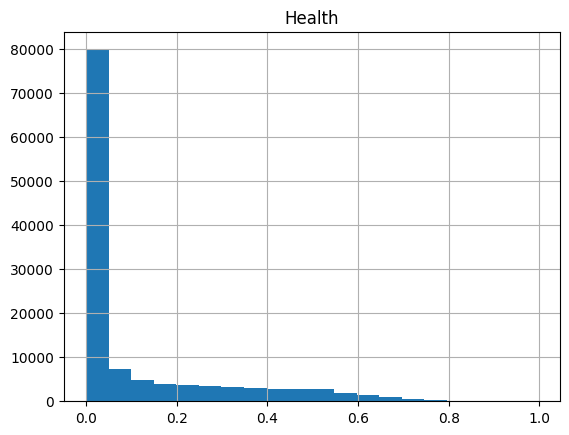

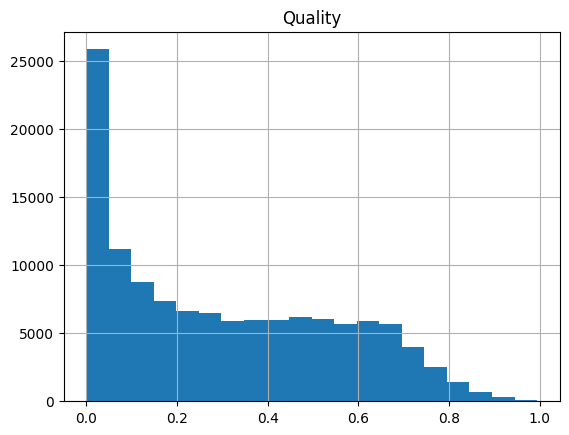

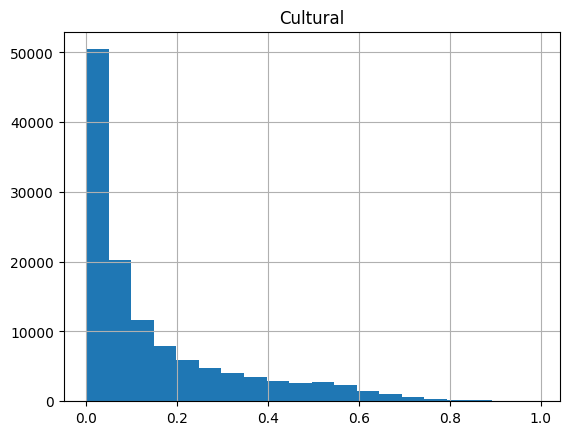

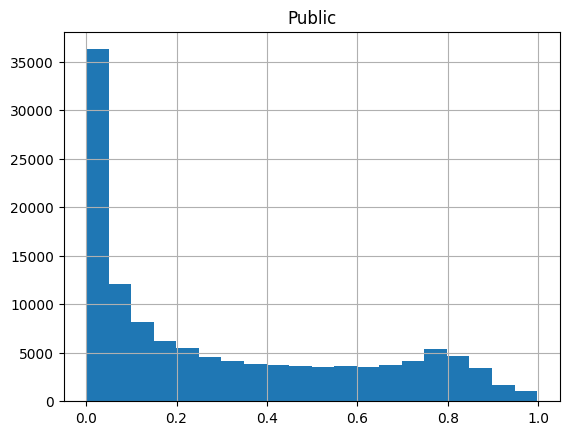

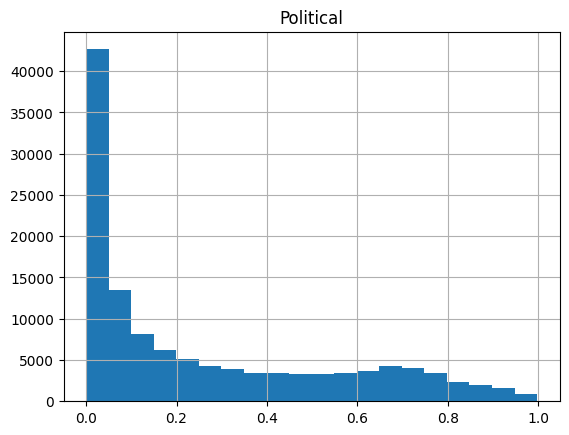

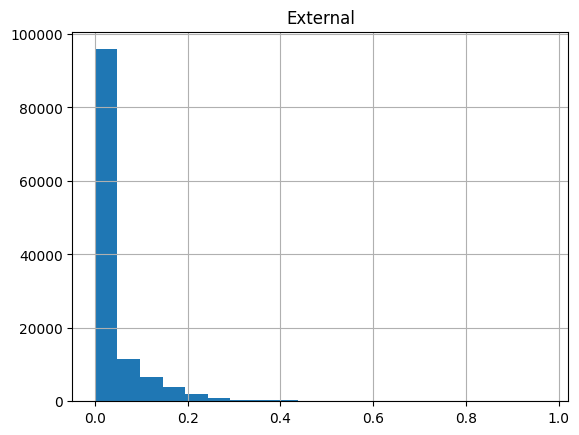

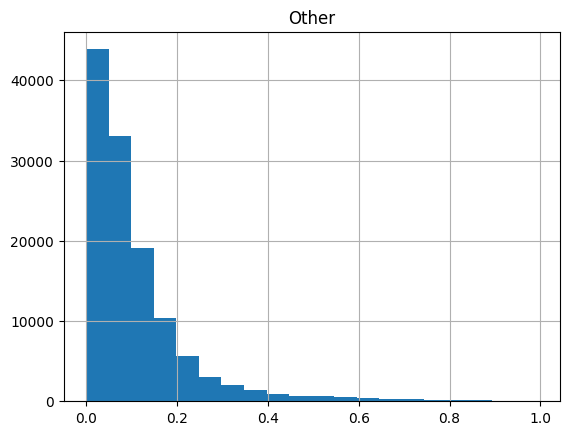

In [13]:
# todo mean + std in title
for col in all_cop_reports.columns:
    all_cop_reports.hist(column=col, bins=20)

In [22]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def calculate_percentile(column, value):
    return round(stats.percentileofscore(column, value, kind='rank'), 1)

def calculate_percentiles_of_mean(mean, data=all_cop_reports):
    percentiles_df = pd.DataFrame()
    for col in mean.columns:
        percentiles = []
        for value in mean[col]:
            percentiles.append(calculate_percentile(data[col], value))
        percentiles_df[col] = percentiles

    return percentiles_df

def read_and_merge_label_files(file_paths):
    assert(file_paths)

    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df_mean = df.mean().to_frame(name=file_path)
        df_mean.index.name = "Name"
        df_list.append(df_mean)

    merged_df = df_list[0]
    for elm in df_list[1:]:
        merged_df = pd.merge(merged_df, elm, on="Name")

    merged_df = merged_df.iloc[::-1]
    return merged_df

def plot_merged_labels(merged_df, title, custom_names, output_dir="", percentiles_df=None):
    merged_df.columns = custom_names
    plt.figure(figsize=(8, 6))
    merged_df.plot(kind="barh", figsize=(8, 6), width=0.7)
    plt.legend(custom_names)

    if percentiles_df is not None:
         num_columns = len(percentiles_df.columns)
         for row in percentiles_df.iterrows():
            i = num_columns
            for col in percentiles_df.columns:
                i -= 1
                plt.plot([row[1][col]], [i], color="black", marker="|", markersize=10, linestyle="None")

    plt.xlabel("")
    plt.ylabel("")
    plt.title(title)
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.xlim(0, 1)
    for x in [0.2, 0.4, 0.6, 0.8]:
        plt.axvline(x=x, color="grey", linestyle="--")


    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(
            os.path.join(output_dir, title),
            bbox_inches="tight",
        )
    plt.show()
    plt.close()

In [65]:
percentiles_df = all_cop_reports.quantile([0.1, 0.3, 0.7, 0.9])
percentiles_df.head()

,Economic,Capacity,Morality,Fairness,"Legality,",Policy,Crime,Security,Health,Quality,Cultural,Public,Political,External,Other
0.1,0.050049,0.081260,0.002060,0.008827,0.001009,0.010084,0.001044,0.009226,0.000308,0.012686,0.007613,0.006761,0.006602,0.000953,0.012102
0.3,0.344731,0.307956,0.014260,0.047838,0.004330,0.050902,0.006487,0.073001,0.001665,0.098300,0.029603,0.051602,0.036535,0.003920,0.041170
0.7,0.783017,0.639145,0.124982,0.272745,0.074943,0.327626,0.149610,0.439115,0.087846,0.461352,0.170280,0.469232,0.379472,0.029251,0.119446
0.9,0.916297,0.791468,0.448202,0.602199,0.411854,0.697208,0.471965,0.680015,0.420636,0.667232,0.434568,0.786785,0.717324,0.120548,0.233263


<Figure size 800x600 with 0 Axes>

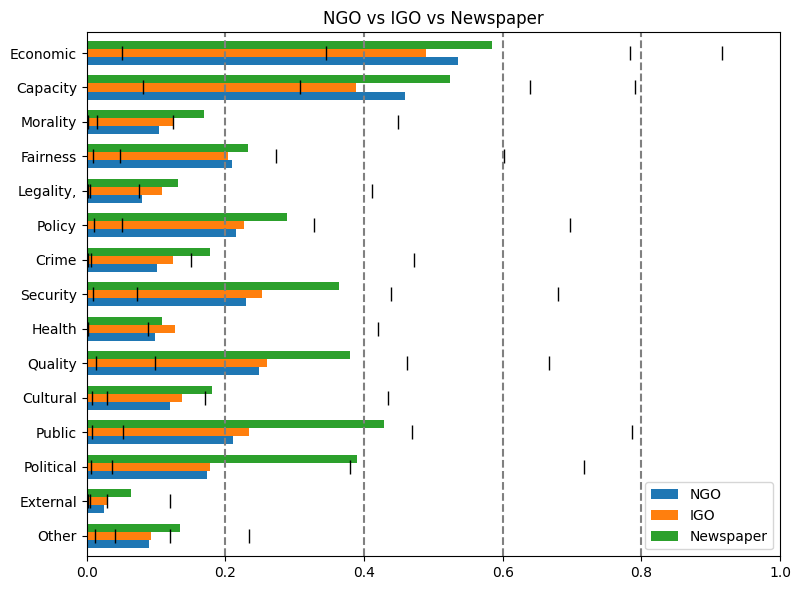

In [20]:
# Usage example
title = "NGO vs IGO vs Newspaper"
output_dir = "COP/plots/custom_compare_label/"

file_paths = [
    "COP/dumps/labels/NGO.csv",
    "COP/dumps/labels/IGO.csv",
    "COP/dumps/labels/Newspapers.csv",
]
custom_names = [
    "NGO",
    "IGO",
    "Newspaper",
]

percentiles_df = all_cop_reports.quantile([0.1, 0.3, 0.7, 0.9])
merged_df = read_and_merge_label_files(file_paths)
plot_merged_labels(merged_df, title, custom_names, output_dir, percentiles_df)

In [23]:
for file in merged_df.columns:
    print(f"Percentiles of {file}")
    sample = merged_df[file]
    for col in all_cop_reports.columns:
        print(f"\t{col}: {calculate_percentile(all_cop_reports[col], sample[col])}")

Percentiles of NGO
	Economic: 44.0
	Capacity: 46.2
	Morality: 66.7
	Fairness: 63.5
	Legality,: 70.8
	Policy: 60.1
	Crime: 65.0
	Security: 51.3
	Health: 71.0
	Quality: 48.8
	Cultural: 61.8
	Public: 52.1
	Political: 54.9
	External: 66.6
	Other: 58.4
Percentiles of IGO
	Economic: 40.3
	Capacity: 38.3
	Morality: 70.1
	Fairness: 62.7
	Legality,: 74.2
	Policy: 61.4
	Crime: 67.5
	Security: 53.7
	Health: 73.4
	Quality: 50.0
	Cultural: 65.0
	Public: 54.2
	Political: 55.3
	External: 69.8
	Other: 59.7
Percentiles of Newspaper
	Economic: 48.1
	Capacity: 54.3
	Morality: 75.3
	Fairness: 66.1
	Legality,: 76.3
	Policy: 67.0
	Crime: 72.4
	Security: 63.7
	Health: 71.8
	Quality: 62.0
	Cultural: 71.4
	Public: 67.6
	Political: 70.6
	External: 81.6
	Other: 74.5
